<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Solar-climate connections over the Common Era 
by _Feng Zhu, NUIST_

Variations in solar irradiance have been hypothesized to be responsible for part of the variability in global mean surface temperature (GMST) over the Common Era (the last 2,000 years or so). In this notebook we test this hypothesis using wavelet transform coherency between reconstructions of solar irradiance and GMST. For the former we use the SATIRE-H dataset ([Vieira et al. 2011](http://dx.doi.org/10.1051/0004-6361/201015843)), as compiled by [Barboza et al. (2020)](https://doi.org/10.1007/s13253-019-00372-4). For the latter we use the ensemble of [Neukom et al (2019)](https://www.nature.com/articles/s41561-019-0400-0), who applied 7 different statistical methods to the [PAGES 2k database](https://www.nature.com/articles/sdata201788).  

We reproduce Fig 16 of [the supplementary online material](https://static-content.springer.com/esm/art%3A10.1038%2Fs41561-019-0400-0/MediaObjects/41561_2019_400_MOESM1_ESM.pdf), section 5.3. 

In [1]:
# load packages
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import os
from matplotlib import gridspec
import matplotlib.pyplot as plt
from tqdm import tqdm

## Read data

In [2]:
database_path = '../data/'
forcing_filename = 'Neukom2019_forcing.csv'
GMST_filename = 'Neukom2019_GMST_recon_medians_selection.txt'

forcing_df = pd.read_csv(os.path.join(database_path, forcing_filename)) 
GMST_df = pd.read_table(os.path.join(database_path, GMST_filename))

In [3]:
GMST_df

,Year,CPS_R-FDR_longcalib,PCR_R-FDR_longcalib,M08_R-FDR_longcalib,PAI_R-FDR_longcalib,OIE_R-FDR_longcalib,BHM_R-FDR_longcalib,LMR_R-FDR_longcalib
0,1,-0.3298,-0.3844,-0.1543,-0.4421,-0.2994,-0.3913,-0.1115
1,2,-0.2933,-0.3744,-0.1962,-0.3966,-0.2530,-0.4667,-0.1084
2,3,-0.2343,-0.3384,-0.2287,-0.2909,-0.1520,-0.4396,-0.1017
3,4,-0.2238,-0.3179,-0.2779,-0.2047,-0.1795,-0.3895,-0.0703
4,5,-0.2823,-0.3474,-0.2609,-0.2533,-0.1047,-0.2997,-0.0910
...,...,...,...,...,...,...,...,...
1995,1996,0.3537,0.3341,0.2771,0.1898,0.2574,0.4431,0.2220
1996,1997,0.2967,0.3601,0.4979,0.2811,0.3076,0.6538,0.2145
1997,1998,0.4652,0.5391,0.5308,0.3789,0.4660,0.7249,0.3672
1998,1999,0.3457,0.3341,0.3281,0.3561,0.3121,0.4341,0.2377


In [4]:
forcing_df

,CO2,volcanic,solar
0,277.450000,0.004314,1365.551796
1,277.140000,0.004312,1365.544193
2,277.160000,0.004312,1365.537762
3,277.160000,0.010717,1365.532407
4,277.160000,0.009114,1365.528030
...,...,...,...
1995,360.238956,0.006074,1365.866895
1996,362.004961,0.004860,1365.855477
1997,363.251962,0.004804,1365.846130
1998,365.932958,0.004623,1365.839096


## Plot timeseries

In [5]:
solar = forcing_df['solar'].values
to = GMST_df['Year'].values
ts_solar = pyleo.Series(time=to, value=solar, label='Total Solar Irradiance', time_name='Time', time_unit='yr', value_name='TSI', value_unit=r'W m$^{-2}$')
exp_names = list(GMST_df.columns.values)[1:]

In [6]:
ts = {}
for i, exp in enumerate(exp_names):
    ts[exp] = pyleo.Series(time=to, value=GMST_df[exp].values, label=exp, time_name='Time', time_unit='yr', value_name='T anom.', value_unit='K')

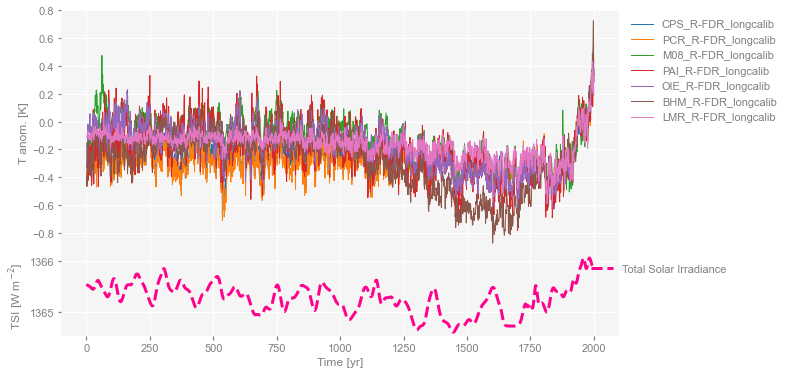

In [7]:
pyleo.set_style('web')
gs = gridspec.GridSpec(4, 1)
gs.update(wspace=0, hspace=0)

fig = plt.figure(figsize=[10, 6])
ax1 = plt.subplot(gs[0:3, :])
for i, exp in enumerate(exp_names):
    ts[exp].plot(ax=ax1,linewidth=1)
ax1.legend(bbox_to_anchor=(1.3, 1.0), loc='upper right')
    
ax2 = plt.subplot(gs[3, :], sharex=ax1)
ts_solar.plot(ax=ax2, linestyle='--', linewidth=3, color='black')    
ax2.legend(bbox_to_anchor=(1.21, 1.0), loc='upper right')

## Wavelet coherency analysis

This uses pyleoclim's [wavelet coherence method](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#pyleoclim.core.ui.Series.wavelet_coherence). Since the series are evenly-spaced, it will use the [CWT](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html?highlight=cwt#pyleoclim.utils.wavelet.cwt_coherence) method by default.

In [8]:
scale = np.logspace(1, 11, num=51, base=2)
freq = 1/scale[::-1]
col = {}
for exp in tqdm(exp_names):
    print('Evaluating coherence with '+ exp +'\n')
    col[exp] = ts_solar.wavelet_coherence(ts[exp], settings={'freq':freq}).signif_test(number=200, mute_pbar=True)

  0%|                                                                                                                            | 0/7 [00:00<?, ?it/s]

Evaluating coherence with CPS_R-FDR_longcalib



 14%|████████████████▌                                                                                                   | 1/7 [00:24<02:29, 24.90s/it]

Evaluating coherence with PCR_R-FDR_longcalib



 29%|█████████████████████████████████▏                                                                                  | 2/7 [00:49<02:03, 24.62s/it]

Evaluating coherence with M08_R-FDR_longcalib



 43%|█████████████████████████████████████████████████▋                                                                  | 3/7 [01:15<01:41, 25.45s/it]

Evaluating coherence with PAI_R-FDR_longcalib



 57%|██████████████████████████████████████████████████████████████████▎                                                 | 4/7 [01:42<01:18, 26.02s/it]

Evaluating coherence with OIE_R-FDR_longcalib



 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 5/7 [02:08<00:52, 26.11s/it]

Evaluating coherence with BHM_R-FDR_longcalib



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6/7 [02:35<00:26, 26.32s/it]

Evaluating coherence with LMR_R-FDR_longcalib



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 25.95s/it]


Now we plot the result for each reconstruction. The colors represent the level of coherency, and the arrows represent the phase angle (right = 0 , left = 180, top = 90, bottom = 270 degrees, and everything in between).

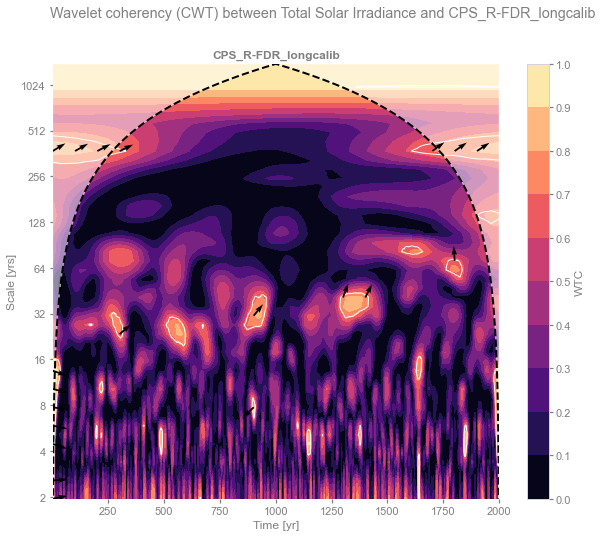

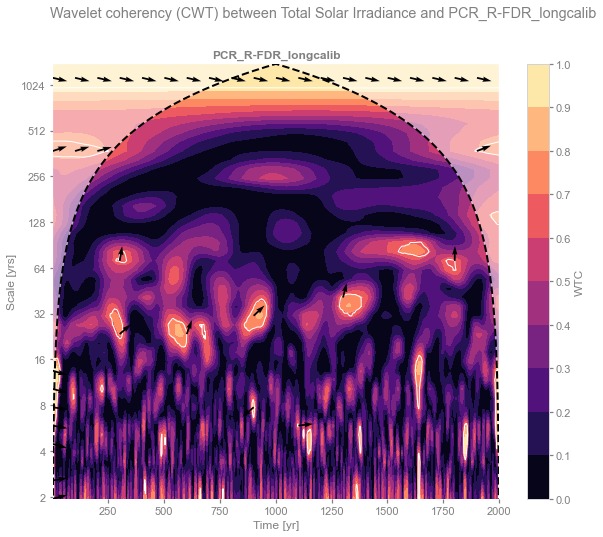

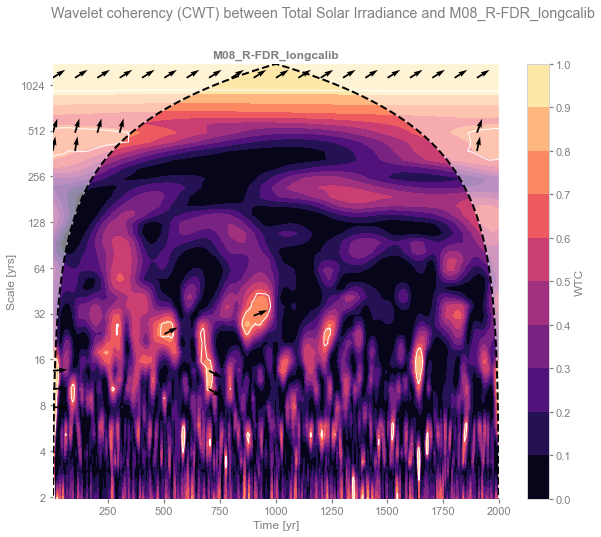

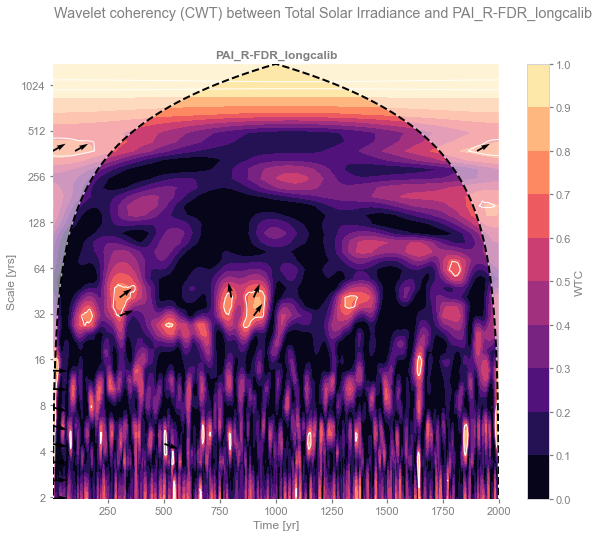

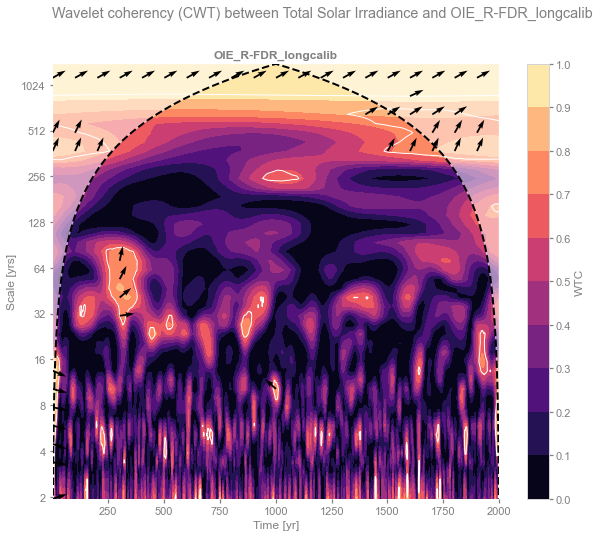

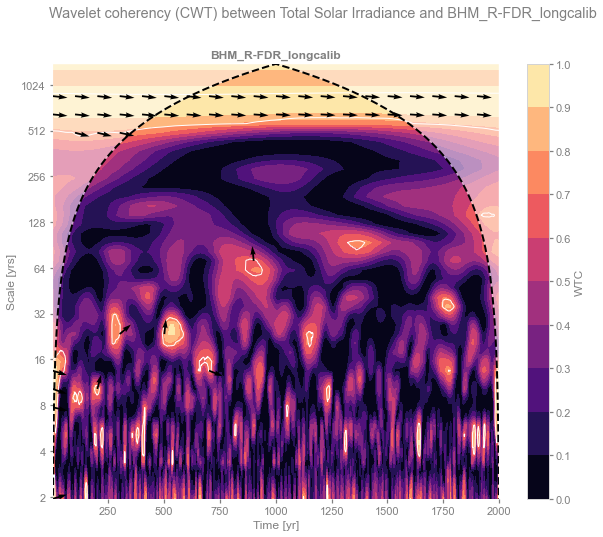

In [9]:
period_ticks = np.logspace(1, 11, num=11, base=2)
for exp in exp_names:
    fig, ax = col[exp].plot(yticks=period_ticks)
    ax.set_title(exp, fontweight='bold')
    
pyleo.closefig()

In some cases one can see a hint of an in-phase relationship (high coherency, phase angle close to 0) at periods longer than 500 years, but it flirts with the cone of influence (region of the scalogram affected by edge effects) and does not appear significant against a red noise (AR(1)) benchmark, except in the "BHM" reconstruction of [Barboza et al (2019)](https://link.springer.com/article/10.1007/s13253-019-00372-4), which uses this solar forcing as one of its predictors (and it is therefore not surprising that it should be coherent with it, though as the article shows, that is a very weak signal).  We conclude that there is no evidence for a robust solar influence on climate these reconstructions.